In [14]:
import sagemaker
from sagemaker import get_execution_role
import io
import boto3

import json
import pickle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import accimage
from PIL import Image
import random

In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
print(role)
s3 = boto3.resource('s3')
bucket_name = 'schen5-bucket01'
bucket = s3.Bucket(bucket_name)
prefix = 'train'

arn:aws:iam::063714881540:role/service-role/AmazonSageMaker-ExecutionRole-20210501T171014


In [9]:
def default_loader(path):
    img_bytes = s3.Object(bucket_name, path).get()['Body'].read()
    # e.g. path: 'train/21JBED3YWoL._AC_.png'
    return Image.open(io.BytesIO(img_bytes)).convert('RGB')

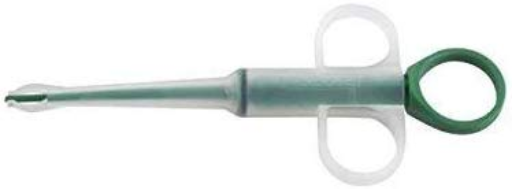

In [10]:
default_loader('train/21JBED3YWoL._AC_.png')

In [8]:
img_bytes = s3.Object(bucket_name, 'train/21JBED3YWoL._AC_.png').get()['Body'].read()
print(Image.open(io.BytesIO(img_bytes)))

<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x189 at 0x7F055E8A5EB8>


In [3]:
for object_summary in bucket.objects.filter(Prefix=prefix):
    key = object_summary.key
    print(key)
    if key == 'train/.DS_Store':
        continue
    file_stream = io.BytesIO()
    object = bucket.Object(key)
    object.download_fileobj(file_stream)
    img = mpimg.imread(file_stream, 'jpg')
    im = Image.fromarray((img * 255).astype(np.uint8)).convert('RGB')
    break

train/.DS_Store
train/21JBED3YWoL._AC_.png


In [54]:
img_bytes = s3.Object(bucket_name, 'train/21JBED3YWoL._AC_.png').get()['Body'].read()

In [60]:
image = Image.open(io.BytesIO(img_bytes))

In [4]:
object_summary.key[len(prefix)+1:-4]

'21JBED3YWoL._AC_'

(189, 512, 4)


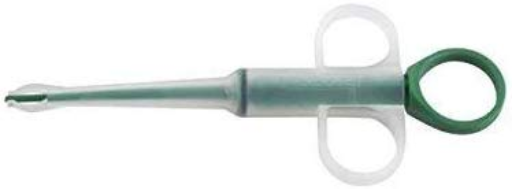

In [5]:
print(img.shape)
im = Image.fromarray((img * 255).astype(np.uint8)).convert('RGB')
im

In [20]:
def make_dataset(directory, labels_dic):
    images = []
    for object_summary in bucket.objects.filter(Prefix=directory):
        path = object_summary.key
        fname = object_summary.key[len(directory)+1:-4]
        try:
            item = (path, labels_dic[fname])
            images.append(item)
        except:
            continue
    print(len(images))
    random.Random(4).shuffle(images)
    return images

In [16]:
response = s3.Object(bucket_name, 'labels.json').get()['Body']
labels_dic = json.loads(response.read())
# labels['21JBED3YWoL._AC_']

In [30]:
samples = make_dataset('train', make_labels())

1000


In [27]:
def make_labels():
    def mean(scores):
        return np.mean([v for v in scores.values()])
    def mean2(scores):
        out = []
        for v in scores.values():
            out += v
        return np.mean(out)
    response = s3.Object(bucket_name, 'labels.json').get()['Body'].read()
    labels_dic = json.loads(response)
    out = {}
    for file_name, scores in labels_dic.items():
        pinch = mean(scores['pinch'])
        clench = mean(scores['clench'])
        poke = mean(scores['poke'])
        palm = mean(scores['palm'])
        familiarity = mean2(scores['familiarity'])
        size = scores['size']
        out[file_name] = [pinch, clench, poke, palm, familiarity, size]
    return out

In [29]:
# make_labels()

In [31]:
[s[1] for s in samples]

[[51.285714285714285, 85.125, 52.75, 57.75, 68.58064516129032, 128],
 [41.2, 72.4, 97.0, 61.25, 81.42105263157895, 256],
 [73.28571428571429, 88.0, 43.5, 60.111111111111114, 89.93939393939394, 128],
 [82.57142857142857, 80.11111111111111, 48.875, 36.25, 82.03125, 128],
 [64.57142857142857, 80.71428571428571, 29.857142857142858, 59.0, 91.0, 512],
 [79.28571428571429,
  77.14285714285714,
  35.22222222222222,
  25.25,
  77.09677419354838,
  128],
 [62.0, 86.88888888888889, 27.75, 29.75, 73.5, 256],
 [39.888888888888886, 72.25, 64.375, 51.333333333333336, 70.8529411764706, 64],
 [47.75, 90.25, 87.66666666666667, 43.25, 91.12121212121212, 256],
 [52.375, 64.77777777777777, 27.0, 40.25, 56.11764705882353, 128],
 [45.4, 86.8, 69.875, 70.5, 76.58333333333333, 256],
 [78.33333333333333,
  81.33333333333333,
  68.14285714285714,
  52.333333333333336,
  83.32,
  64],
 [79.125, 74.0, 64.5, 53.714285714285715, 54.354838709677416, 64],
 [25.75, 63.0, 52.4, 67.16666666666667, 52.53846153846154, 512]